In [1]:
!pip install d2l==0.14.4

     |████████████████████████████████| 61kB 1.9MB/s 


In [24]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

F.one_hot(torch.tensor([0, 2]), len(vocab))

X = d2l.reshape(torch.arange(10), (2, 5))
F.one_hot(X.T, 28).shape

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

num_hiddens = 512
model = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                        init_rnn_state, rnn)
state = model.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = model(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

def predict_ch8(prefix, num_preds, model, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = model.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: d2l.reshape(torch.tensor(
        [outputs[-1]], device=device), (1, 1))
    for y in prefix[1:]:  
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): 
        y, state = model(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def grad_clipping(model, theta):  
    """Clip the gradient."""
    if isinstance(model, nn.Module):
        params = [p for p in model.parameters() if p.requires_grad]
    else:
        params = model.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch_ch8(model, train_iter, loss, updater, device, 
                    use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = model.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(model, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
             
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = model(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(model, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(model, 1)
            updater(batch_size=1)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[1, num_epochs])
    if isinstance(model, nn.Module):
        updater = torch.optim.SGD(model.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(model.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, model, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        if epoch % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))




perplexity 1.5, 17514.0 tokens/sec on cpu
time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


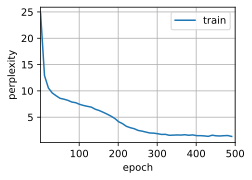

In [25]:
train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)